<a href="https://colab.research.google.com/github/kasprova/advanced_customer_analytics/blob/master/notebooks/customer_clusterization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CLUSTERISATION (update 2019-10-15)

In [0]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline 
plt.style.use('ggplot')
#plt.style.use('default')
plt.rcParams["figure.figsize"] = (30,30)

#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
#from cuml import DBSCAN as cuDBSCAN, KMeans as cuKMeans, PCA as cuPCA
from collections import Counter

### Load Data

In [0]:
#mount google drive to get access to the data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -q "drive/My Drive/analytics/universal_features_manual_cat.parquet.zip"

In [0]:
universal_features = "universal_features_manual_cat.parquet"

In [0]:
#!unzip -q "drive/My Drive/grocery_store_data/universal_features_manual_cat.parquet.zip"
#universal_features = "universal_features_manual_cat.parquet"

In [0]:
data = pd.read_parquet(universal_features)
data.columns

Index(['month_id', 'household_id', 'recency', 'frequency', 'monetary', 'churn',
       'discount_number__store_coupon', 'discount_value__store_coupon',
       'discount_number__manufacture_coupon',
       'discount_value__manufacture_coupon', 'discount_number__misc_credit',
       'discount_value__misc_credit', 'discount_number__prologic_credit',
       'discount_value__prologic_credit', 'discount_number__total',
       'discount_value__total', 'deposite_number__bottle',
       'deposite_value__bottle', 'return_number__bottle',
       'return_value__bottle', 'refund_number', 'refund_value',
       'cat_m_alco_tabacco_paid_amount_pcnt',
       'cat_m_baby_and_pets_paid_amount_pcnt', 'cat_m_baking_paid_amount_pcnt',
       'cat_m_diary_paid_amount_pcnt', 'cat_m_drinks_paid_amount_pcnt',
       'cat_m_grains_paid_amount_pcnt', 'cat_m_greens_paid_amount_pcnt',
       'cat_m_misc_paid_amount_pcnt', 'cat_m_prepared_food_paid_amount_pcnt',
       'cat_m_proteins_paid_amount_pcnt', 'cat_m_saus

## 1. Data Preprocessing

In [0]:
ignore_list = ['month_id', 'household_id']
features = [c for c in data.columns if c not in ignore_list]

Raw data


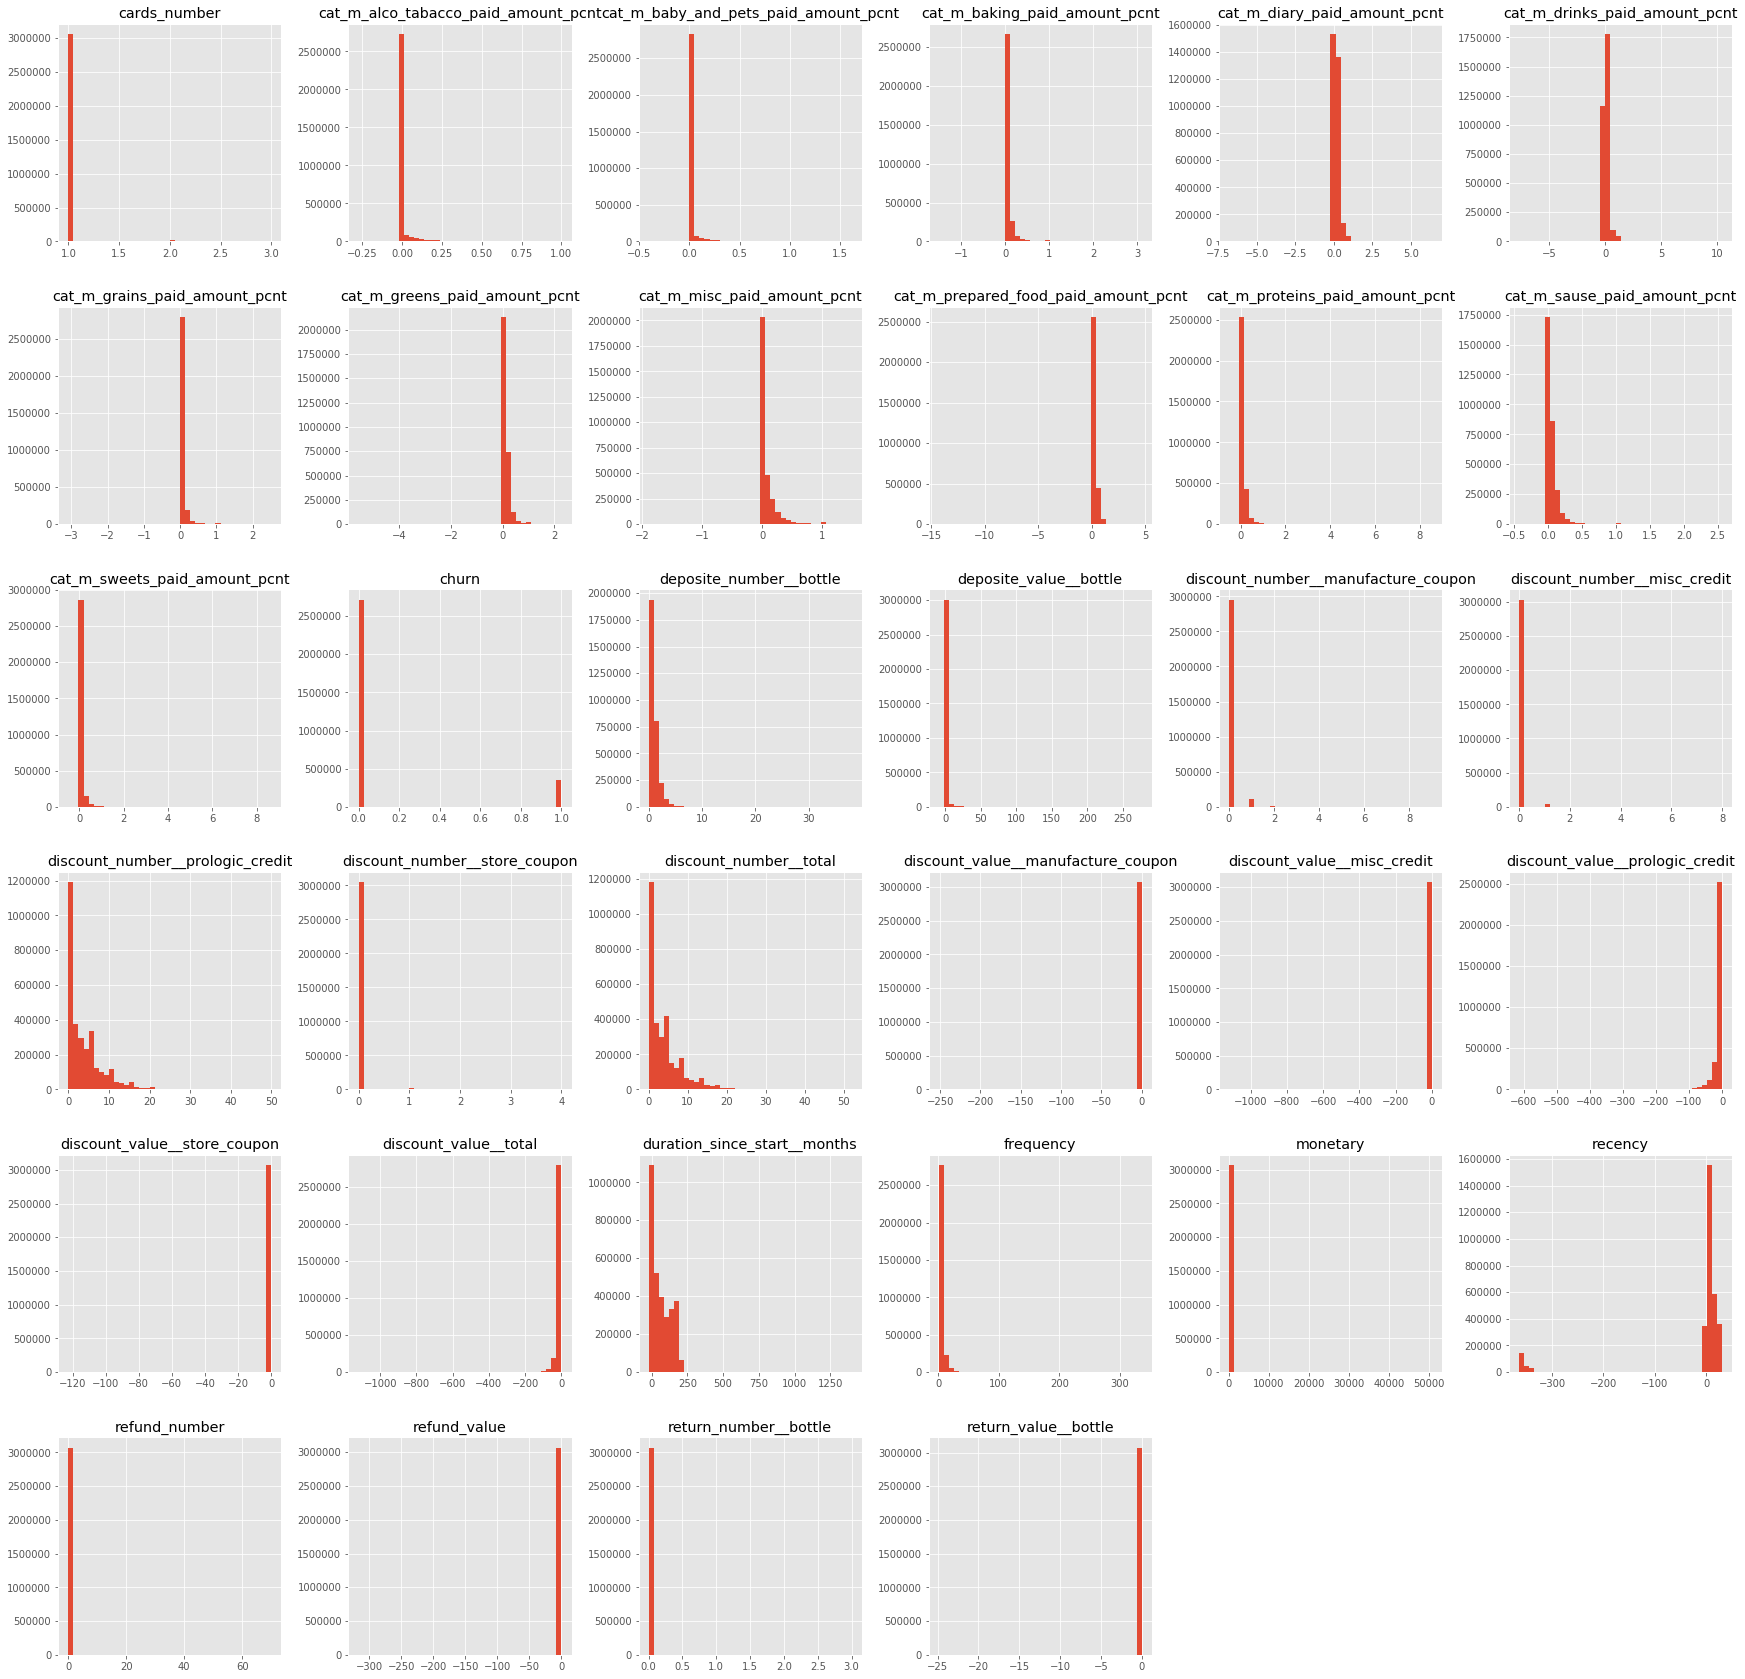

In [0]:
df = data.copy()
#df = data[data['month_id'].isin(['201709','201708'])]
df[features].hist(bins=40)
print("Raw data")

In [0]:
# transform from negative to positive values
df[['discount_value__manufacture_coupon',
 'discount_value__misc_credit',
 'discount_value__prologic_credit',
 'discount_value__store_coupon',
 'discount_value__total',
 'refund_value',
 'return_value__bottle']] = - df[[
 'discount_value__manufacture_coupon',
 'discount_value__misc_credit',
 'discount_value__prologic_credit',
 'discount_value__store_coupon',
 'discount_value__total',
 'refund_value',
 'return_value__bottle']]

#applying log(x+1) transformation for features containing 'money' value
df[['monetary']] = np.log1p(df[['monetary']])

#applying MinMaxScaler scaler
#scaler = MinMaxScaler()
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = features

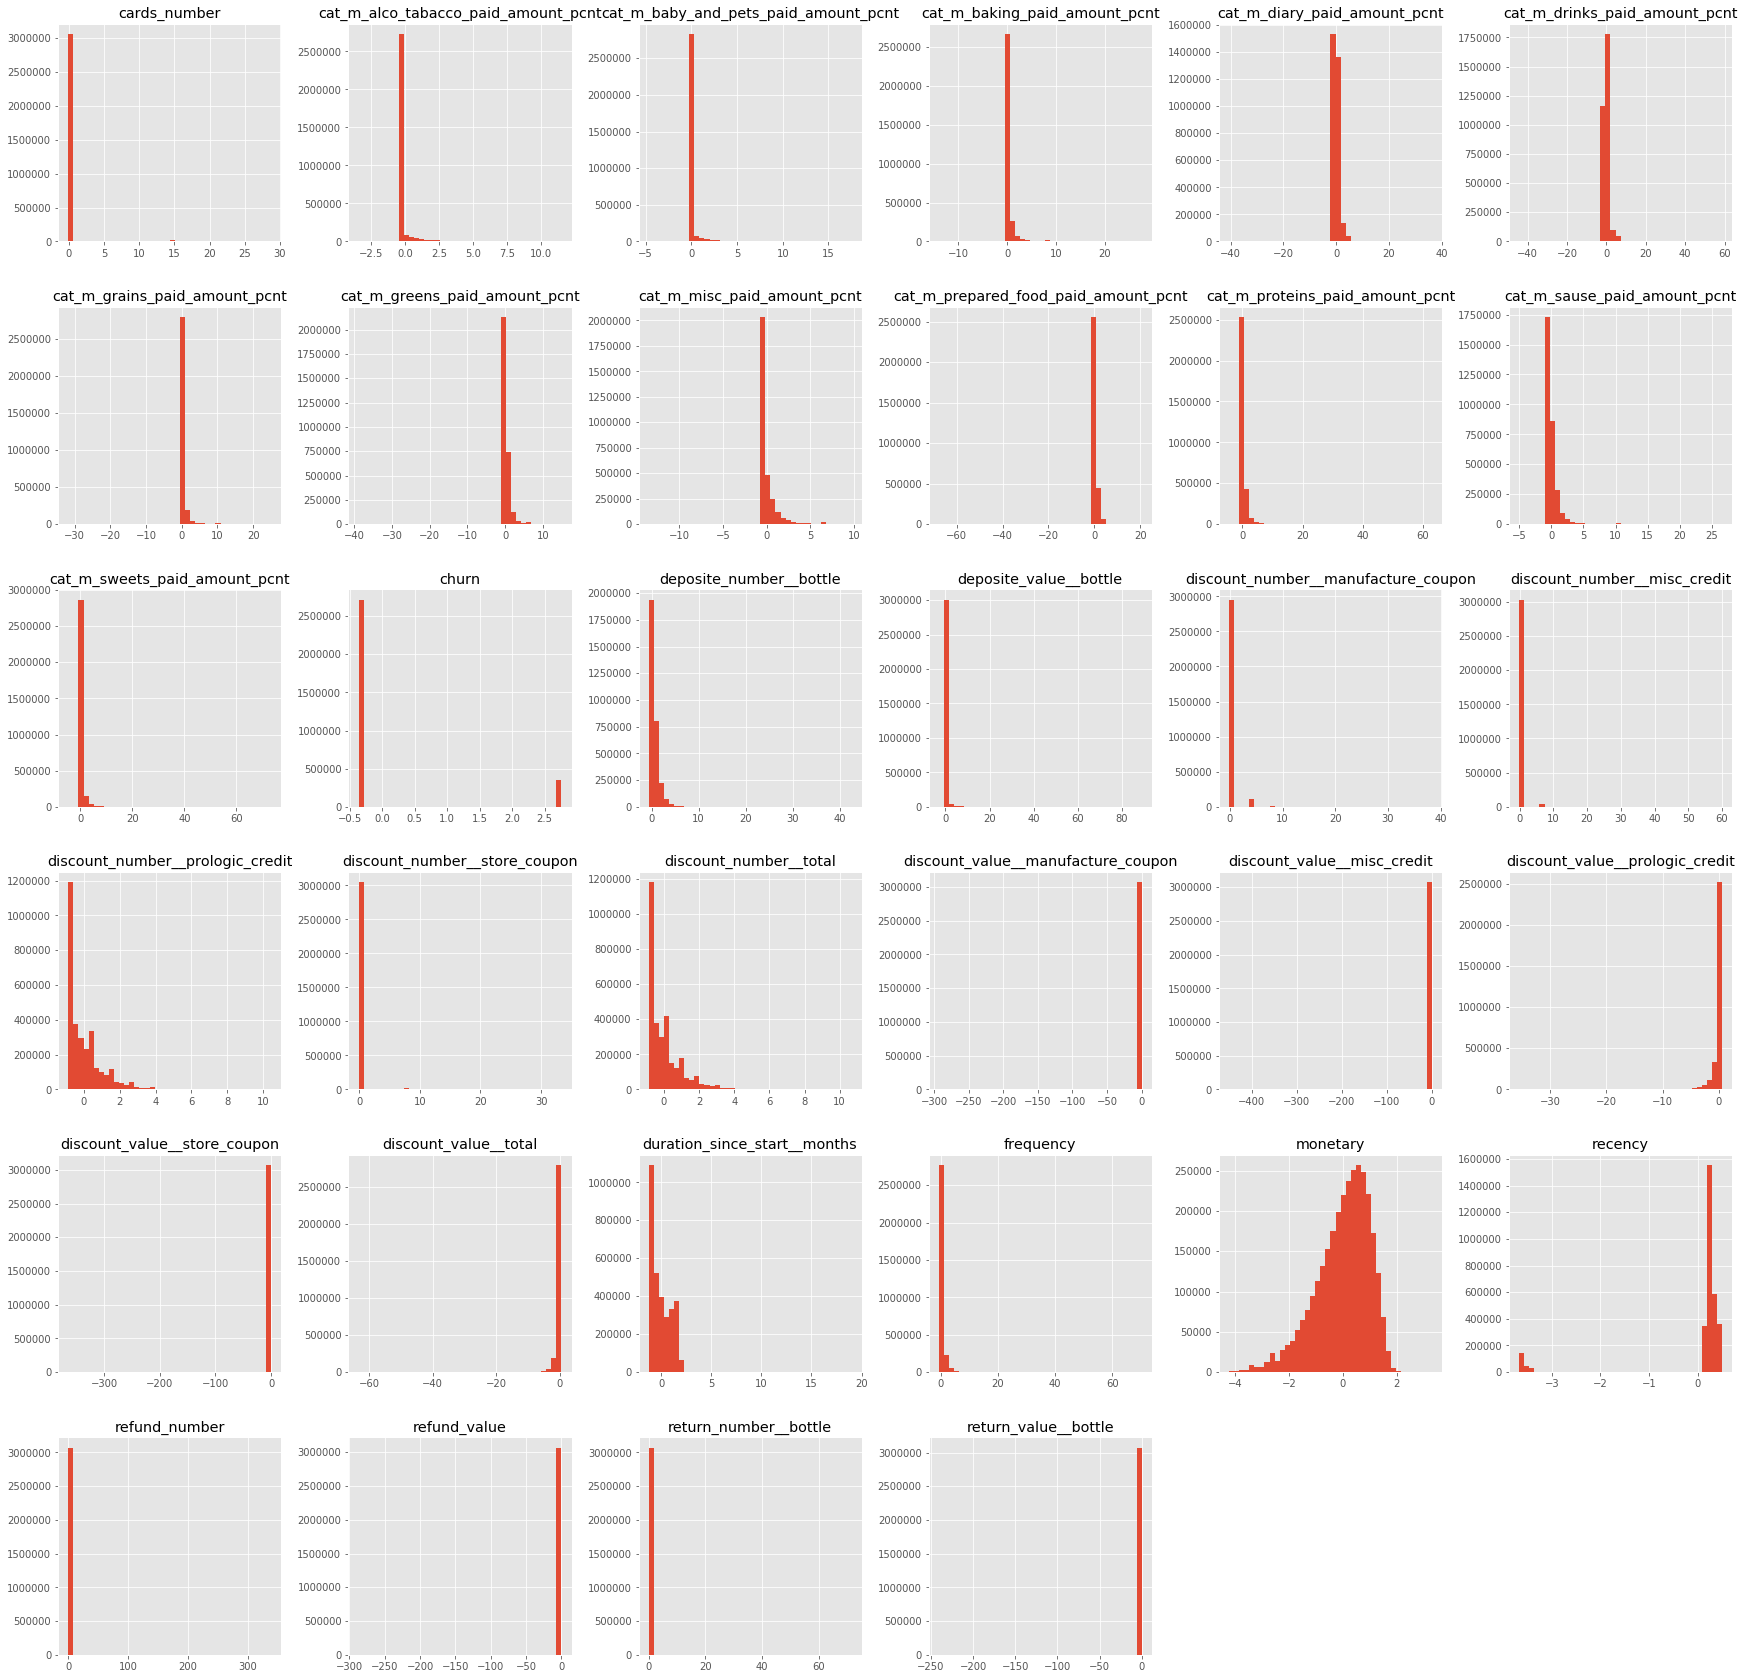

In [0]:
scaled_df.hist(bins=40)
plt.show()

In [17]:
scaled_df.head()

,recency,frequency,monetary,churn,discount_number__store_coupon,discount_value__store_coupon,discount_number__manufacture_coupon,discount_value__manufacture_coupon,discount_number__misc_credit,discount_value__misc_credit,discount_number__prologic_credit,discount_value__prologic_credit,discount_number__total,discount_value__total,deposite_number__bottle,deposite_value__bottle,return_number__bottle,return_value__bottle,refund_number,refund_value,cat_m_alco_tabacco_paid_amount_pcnt,cat_m_baby_and_pets_paid_amount_pcnt,cat_m_baking_paid_amount_pcnt,cat_m_diary_paid_amount_pcnt,cat_m_drinks_paid_amount_pcnt,cat_m_grains_paid_amount_pcnt,cat_m_greens_paid_amount_pcnt,cat_m_misc_paid_amount_pcnt,cat_m_prepared_food_paid_amount_pcnt,cat_m_proteins_paid_amount_pcnt,cat_m_sause_paid_amount_pcnt,cat_m_sweets_paid_amount_pcnt,duration_since_start__months,cards_number
0,0.259346,-0.245688,-0.109835,-0.362563,-0.090943,0.039598,-0.190125,0.099821,-0.109626,0.029204,-0.190600,0.228985,-0.202358,0.231874,-0.605995,-0.196624,-0.032035,0.015989,-0.04427,0.044409,-0.231662,-0.219669,2.870736,-0.838178,-0.694868,2.296683,-0.674933,-0.510280,-0.248874,0.353855,0.058258,-0.402754,1.673118,-0.06832
1,0.185379,4.621027,1.182173,-0.362563,-0.090943,0.039598,-0.190125,0.099821,-0.109626,0.029204,0.715383,-0.728392,0.685759,-0.696672,0.529409,0.094153,-0.032035,0.015989,-0.04427,0.044409,-0.231662,-0.219669,-0.442963,-0.767191,0.106966,0.055630,0.504240,0.532374,1.078588,-0.608582,-0.415972,-0.402754,1.188179,-0.06832
2,0.227646,-0.457285,-1.051100,-0.362563,-0.090943,0.039598,-0.190125,0.099821,-0.109626,0.029204,-0.643592,0.461272,-0.646417,0.457167,-0.605995,-0.196624,-0.032035,0.015989,-0.04427,0.044409,-0.231662,-0.219669,-0.442963,1.657909,-0.694868,-0.448550,0.995436,-0.510280,0.443352,-0.608582,-0.512319,-0.402754,1.045550,-0.06832
3,0.365012,-0.034092,0.434338,-0.362563,-0.090943,0.039598,-0.190125,0.099821,-0.109626,0.029204,-0.417096,0.457744,-0.424388,0.453745,0.529409,-0.099699,-0.032035,0.015989,-0.04427,0.044409,-0.231662,-0.219669,0.096476,-0.838178,0.170924,0.479458,-0.162785,-0.510280,-0.055467,2.023980,-0.014224,-0.402754,1.673118,-0.06832
4,0.259346,0.812293,1.376787,-0.362563,-0.090943,0.039598,-0.190125,0.099821,-0.109626,0.029204,0.262392,-0.155613,0.241700,-0.141141,0.529409,-0.180470,-0.032035,0.015989,-0.04427,0.044409,-0.231662,-0.219669,0.035165,1.016255,-0.511249,-0.064324,1.056802,-0.306336,-0.532086,0.294569,-0.512319,-0.096349,1.673118,-0.06832


## 2.Segmentation: K-means
Assumptions about data to apply k-means:

    1. Symmetric distribution of variables (not skewed)
    2. Variables with same average values
    3. Variables with same variance



In [18]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from collections import Counter

X = scaled_df.values

clusters_WCSS = {}
WCSS={}

kmeans = KMeans(n_clusters = 50, 
                    init = 'k-means++',
                    max_iter = 300,
                    n_init = 20,
                    random_state =0)
kmeans.fit_predict(X)

array([ 2,  4, 18, ..., 43, 44,  6], dtype=int32)

In [19]:
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=50, n_init=20, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [0]:
pca = PCA(n_components=2, random_state=0)
df_pca = pca.fit_transform(X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

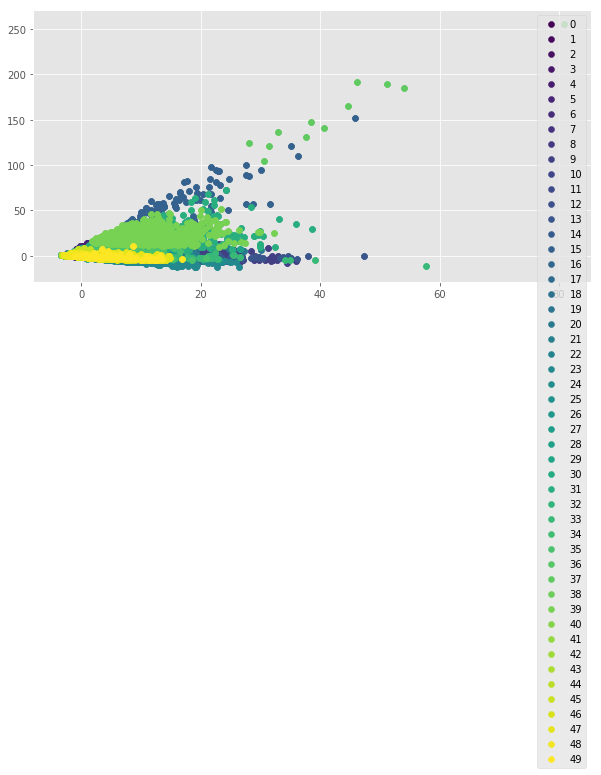

In [22]:
#plot clusters after PCA dimensionality reduction
plt.rcParams["figure.figsize"] = (10,5)
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 50))

for cl in range(0, 50):
    plt.scatter(df_pca[kmeans.labels_==cl,0],
                    df_pca[kmeans.labels_==cl,1],
                    c=colors[cl],
                    label = cl)
plt.legend()
plt.show()

In [23]:
len(kmeans.labels_)

3072638

In [24]:
# print centroids coordinates
df_centr = pd.DataFrame(kmeans.cluster_centers_)
df_centr.columns = features
df_centr.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
recency,-0.050209,0.249169,0.219454,0.273846,0.056317,0.033616,0.069020,-0.167635,-0.049575,-0.192514,-0.117671,0.232856,0.116867,-0.264761,0.058049,-0.188336,0.034427,0.286886,0.285282,0.083929,-0.401982,0.030203,-3.585996,-0.362395,0.279725,-0.169449,0.213938,0.041857,0.093527,0.097930,0.041759,0.017881,0.148441,0.115308,0.168839,-0.040085,-0.023046,-0.424846,0.278829,0.078033,0.331617,0.241911,-0.232038,0.157084,0.217562,0.092350,0.163253,-0.197688,0.201162,-0.026921
frequency,1.436308,0.151216,-0.367636,-0.190721,3.315427,0.328713,-0.263108,1.150347,1.055471,3.676554,1.020171,-0.272029,-0.546857,3.584205,0.011299,0.827407,-0.569657,-0.310288,-0.280379,-0.562289,0.483954,-0.568883,-0.089227,1.751676,-0.630511,0.997802,0.348907,-0.580771,0.708085,-0.613953,0.204402,1.325040,-0.620445,1.568123,-0.484358,1.092232,-0.576646,3.157486,-0.225902,0.649409,-0.536010,0.270681,1.625296,-0.444901,-0.329536,-0.558044,0.540684,0.830496,-0.487492,0.050905
monetary,1.100544,0.499523,-0.363979,0.331892,1.134038,0.602491,-0.183490,0.730503,0.547875,1.552351,0.719078,-0.322532,-1.072103,1.830707,-0.203261,0.723268,-1.445862,-0.065048,-0.226384,-1.060728,0.989861,-1.356011,0.134257,1.176471,-1.894493,0.357020,0.848246,-1.238127,0.586676,-1.358605,0.463303,0.943967,-1.035399,0.902053,-0.634666,0.564514,-1.460585,1.050678,0.090784,0.782786,-0.023732,0.708222,1.284359,-1.078224,-0.342938,-1.311352,0.940683,1.001466,-0.938155,-0.029673
churn,-0.339684,-0.362536,-0.145907,-0.362563,-0.357103,-0.228773,0.136881,-0.085577,-0.220712,-0.352246,-0.329834,-0.194492,0.259751,-0.284545,-0.016782,-0.203343,0.354645,-0.359053,-0.362520,0.500397,-0.362563,0.327889,-0.111906,-0.304258,0.185537,-0.234314,-0.327609,0.438165,-0.218581,2.757929,-0.204642,-0.245930,2.758144,-0.058426,0.075700,-0.196135,0.399738,-0.362563,-0.351421,-0.279595,2.758144,-0.362563,-0.346067,-0.362563,-0.137416,0.494010,-0.316904,-0.284849,-0.362563,-0.029335
discount_number__store_coupon,-0.090943,-0.090943,-0.090943,-0.090943,-0.090943,8.767668,-0.090943,0.502652,0.260690,0.098738,0.018057,-0.090943,-0.086863,0.118052,-0.089443,14.325430,-0.090943,-0.090943,-0.090943,-0.090943,-0.090943,-0.086058,-0.090943,-0.090943,-0.090943,0.138093,-0.090943,-0.090943,-0.050238,-0.090943,-0.090943,1.851231,-0.090943,0.015326,-0.090943,0.013712,-0.087629,16.628638,-0.090943,15.689108,-0.090943,-0.090943,-0.090943,-0.090943,-0.090943,-0.090943,-0.090943,-0.090943,-0.090943,-0.076774
discount_value__store_coupon,0.039598,0.039598,0.039598,0.039598,0.039598,-2.562404,0.039598,-0.402282,-0.070132,-0.019620,0.002977,0.039598,0.038610,-0.016098,0.039158,-65.433662,0.039598,0.039598,0.039598,0.039598,0.039598,0.038007,0.039598,0.039598,0.039598,-0.134697,0.039598,0.039598,0.026978,0.039598,0.039598,-1.201041,0.039598,0.033305,0.039598,0.002010,0.038927,-218.431581,0.039598,-10.886123,0.039598,0.039598,0.039598,0.039598,0.039598,0.039598,0.039598,0.039598,0.039598,0.037836
discount_number__manufacture_coupon,4.714106,-0.190125,-0.184877,-0.190125,-0.175280,4.613937,-0.176706,0.569704,0.364523,0.943161,0.204184,-0.186164,-0.166958,0.451931,-0.116584,8.021202,-0.179110,-0.190125,-0.190125,-0.145052,0.252672,-0.148026,-0.190068,0.148801,-0.189539,0.318047,-0.188591,-0.184283,0.217808,-0.182138,4.361328,7.138392,-0.179350,0.390265,-0.183443,0.202117,-0.169085,9.440714,-0.190125,8.574940,-0.190125,-0.190125,-0.190125,-0.183229,-0.184536,-0.171720,-0.190125,0.066127,-0.183497,-0.045028
discount_value__manufacture_coupon,-2.368943,0.099821,0.098562,0.099821,0.096409,-1.823834,0.096001,-0.406781,-0.178059,-0.511567,-0.090950,0.098870,0.091604,-0.102543,0.064898,-38.858133,0.096296,0.099821,0.099821,0.081591,-0.082914,0.078623,0.099813,-0.065949,0.099709,-0.483051,0.099538,0.097879,-0.098338,0.096927,-1.652275,-21.194001,0.096660,-0.146144,0.098057,-0.078696,0.094208,-91.036393,

In [0]:
final_df = df[['month_id','household_id']].reset_index().merge(pd.DataFrame(kmeans.labels_, columns = ['labels']), right_index = True, left_index = True)
temp = pd.pivot_table(final_df, index = ['household_id'], columns=['month_id'], values=['labels'])
temp.columns = temp.columns.droplevel()
#temp = temp.reset_index()

In [32]:
temp

month_id,201509,201510,201511,201512,201601,201602,201603,201604,201605,201606,201607,201608
household_id,,,,,,,,,,,,
100200078,46.0,0.0,38.0,22.0,46.0,26.0,0.0,46.0,42.0,42.0,46.0,26.0
100200084,38.0,24.5,9.5,22.0,12.0,1.0,48.0,NaN,NaN,1.0,26.0,11.0
100200089,48.0,12.0,16.0,22.0,48.0,18.0,48.0,48.0,17.0,16.0,32.0,NaN
100200092,1.0,17.0,48.0,NaN,46.0,12.0,1.0,1.0,1.0,1.0,34.0,1.0
100200101,24.0,1.0,24.0,22.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0
100200102,48.0,38.0,44.0,22.0,17.0,NaN,46.0,2.0,NaN,6.0,48.0,24.0
100200105,17.0,17.0,1.0,22.0,1.0,18.0,1.0,17.0,48.0,14.0,30.0,1.0
100200109,10.0,19.0,44.0,22.0,18.0,10.0,19.0,19.0,48.0,48.0,NaN,12.0
100200388,NaN,NaN,48.0,22.0,48.0,16.0,48.0,1.0,34.0,2.0,34.0,43.0


In [0]:
transitional_matrix = pd.pivot_table(temp.groupby(['201509','201608']).count().reset_index(), index = ['201509'], columns=['201608'], values=['household_id'])

In [29]:
 transitional_matrix.shape

(76, 85)

**check why cluster number is not integer 0_o **

In [0]:
final_df[['month_id', 'household_id','labels']].to_parquet('cluster_labels.parquet')

In [38]:
#download file to local machine
from google.colab import files
files.download("/content/cluster_labels.parquet")  

MessageError: ignored

In [0]:
#cu_X = cudf.from_pandas(scaled_df)
#clusters_WCSS = {}
#WCSS={}
#kmeans_cuml = cumlKMeans(n_clusters=50)
#kmeans_cuml.fit(cu_X)

In [36]:

final_df[['month_id', 'household_id','labels']]

,month_id,household_id,labels
0,201509,100200513,2
1,201509,100212142,4
2,201509,100212728,18
3,201509,100212958,1
4,201509,100232461,1
5,201509,100233171,1
6,201509,100233254,1
7,201509,100235983,46
8,201509,100236541,1
9,201509,100237857,26


### References:
  https://github.com/rapidsai/notebooks-contrib/blob/master/getting_started_notebooks/intro_tutorials/02_Introduction_to_cuDF.ipynb
  
  rapid setup on colab https://colab.research.google.com/drive/1OqZFKkkyVthnB-Qz-ukb61CM4yKzke_Y#scrollTo=3Uk49SIW5Esf https://medium.com/@kayush206/rapids-on-google-colab-d11df50abcf3 
  
  rapid samples https://github.com/rapidsai/notebooks
  
  markov model explained on DataCamp blog https://www.datacamp.com/community/tutorials/markov-chains-python-tutorial
  
  